In [20]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from google_play_scraper import Sort, reviews, app

import re  
import nltk  
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from nltk import bigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords') 
nltk.download('vader_lexicon')
nltk.download('punkt')


import itertools
import collections

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import networkx as nx


[nltk_data] Downloading package stopwords to C:\Users\Yiwen
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Yiwen
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Yiwen
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### data collection and cleaning 

- Selected a list of popular mental health apps from google play store where there are plentiful user reviews
- Collected app infos and app reviews from google play store and merged the two sets of data

In [2]:
app_ids = [
    'com.calm.android',  #meditation, sleep, relax
    'ai.replika.app', #chatbot
    'de.moodpath.android', #mood tracker
    "com.getsomeheadspace.android", #sleep
    "bot.touchkin", #anxiety chatbot
    "com.meemo_tec.bip_app", #mental health
    "net.daylio", #mood tracker
    'boundless.moodgym', #moodspace: stree relief
    'com.spotlightsix.zentimerlite2', #meditation
    'com.subconscious.thrive', #meditation
    'com.changecollective.tenpercenthappier', #meditation
   
]

In [3]:
#scrape app infos from google play store
app_infos = []

for ap in tqdm(app_ids):
    info = app(ap, lang='en')
    del info['comments']
    app_infos.append(info)
    
app_df = pd.DataFrame(app_infos)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:10<00:00,  1.04it/s]


In [26]:
#scrape reviews data from google play store
app_reviews = []

for ap in tqdm(app_ids):
    print(ap)
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                count = 500,
                sort=sort_order,
                filter_score_with=score
              )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
        app_reviews.extend(rvs)

app_reviews_df = pd.DataFrame(app_reviews)


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

com.calm.android


  9%|███████▌                                                                           | 1/11 [00:26<04:22, 26.25s/it]

ai.replika.app


 18%|███████████████                                                                    | 2/11 [00:58<04:11, 27.98s/it]

de.moodpath.android


 27%|██████████████████████▋                                                            | 3/11 [01:22<03:35, 26.93s/it]

com.getsomeheadspace.android


 36%|██████████████████████████████▏                                                    | 4/11 [01:51<03:13, 27.58s/it]

bot.touchkin


 45%|█████████████████████████████████████▋                                             | 5/11 [02:23<02:52, 28.74s/it]

com.meemo_tec.bip_app


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:32<01:54, 22.92s/it]

net.daylio


 64%|████████████████████████████████████████████████████▊                              | 7/11 [03:06<01:44, 26.16s/it]

boundless.moodgym


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [03:18<01:05, 21.81s/it]

com.spotlightsix.zentimerlite2


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:52<00:51, 25.50s/it]

com.subconscious.thrive


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [04:00<00:20, 20.38s/it]

com.changecollective.tenpercenthappier


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:17<00:00, 23.38s/it]


In [27]:
#join app info and app reviews
app_reviews_df = app_reviews_df[['reviewId', 'userName', 'content', 'score', 'at', 'appId']]
app_reviews_df = app_reviews_df.merge(app_df, on = 'appId', how = 'left')


In [7]:
app_dict = {}
for id in app_ids:
    app_dict[id] = app_df[app_df['appId'] == id]['title'].values.tolist()[0]
app_dict

{'com.calm.android': 'Calm - Meditate, Sleep, Relax',
 'ai.replika.app': 'Replika: My AI Friend',
 'de.moodpath.android': 'MindDoc: Mood Tracker for Depression & Anxiety',
 'com.getsomeheadspace.android': 'Headspace: Meditation & Sleep',
 'bot.touchkin': 'Wysa: stress, depression & anxiety therapy chatbot',
 'com.meemo_tec.bip_app': 'UP! - Depression, Bipolar & Borderline Management',
 'net.daylio': 'Daylio - Diary, Journal, Mood Tracker',
 'boundless.moodgym': 'MoodSpace - Stress, anxiety, & low mood self-help',
 'com.spotlightsix.zentimerlite2': 'Insight Timer - Meditation, Sleep, Music',
 'com.subconscious.thrive': 'Atom: Build a habit of meditation (For Beginners)',
 'com.changecollective.tenpercenthappier': 'Ten Percent Happier - Meditation & Sleep'}

### Analysis

##### Analyze Review Sentiment 

- Looked at the distribution of review sentiment on each of the app and identified the threshold for negative reviews and positive reviews as - 0.1 and 0.6

In [28]:
sia = SentimentIntensityAnalyzer()

app_reviews_df['pol_scores'] = app_reviews_df['content'].apply(lambda x: sia.polarity_scores(str(x)))
app_reviews_df = pd.concat([app_reviews_df.drop(['pol_scores'], axis = 1), app_reviews_df['pol_scores'].apply(pd.Series)], axis = 1)

fig = px.box(app_reviews_df, y="title", x="compound", color="title", title = 'sentiment distribution by app')
fig.update_layout(showlegend = False) 
fig.show()

In [30]:
app_reviews_df['positive_reviews'] = np.where(app_reviews_df['compound'] >= 0.6, True, False)
app_reviews_df['negative_reviews'] = np.where(app_reviews_df['compound'] <= -0.1, True, False)



##### Common Words in Positive Reviews

- Based on the common words in positive reviews, we can easily get a feeling of why the users liked individual app
- We certainly also cannot ignore the fact these words are put out of context
- The common feelings that generate positive feedback from users are they **like** the product because the product make them **feel**  **good** and feel like it **help**s, etc. 

In [31]:
stop_words = set(stopwords.words('english'))

my_collection_words = ['app', 'ai', 'calm', 'replika', 'i\'m', 'app.', 'i\'ve', 'app,', 'it.', 'can\'t']
for app_id in app_ids:
    reviews = []
    df = app_reviews_df[(app_reviews_df['appId'] == app_id) & (app_reviews_df['positive_reviews'] == True)]
    for i in range(len(df[df['appId'] == app_id])):
        reviews.append(df['content'].iloc[i].lower().split())
    reviews_all_words = list(itertools.chain(*reviews))
    stop_words = set(stopwords.words('english'))
    reviews_all_words = [word for word in reviews_all_words if word not in stop_words]
    reviews_all_words = [word for word in reviews_all_words if not word in ENGLISH_STOP_WORDS]
    reviews_all_words = [word for word in reviews_all_words if word not in my_collection_words]

    counts_review_words = collections.Counter(reviews_all_words)
        
    counts_df = pd.DataFrame(counts_review_words.most_common(15), columns = ['word', 'val'])
    title = app_id
    fig = px.bar(counts_df, y='word', x='val', orientation='h', title = 'Common Words in Positive Reviews: {app_name}'.format(app_name = app_dict[app_id])).update_yaxes(categoryorder = 'total ascending')
    fig.show()

##### Common Words in Negative Reviews

- We can see that some of the words that are commonly brought up are **cancel**, **subscription**, **pay** etc along with words like **help**, **like** which could suggest that the users like their experience but do not feel willing to pay for the subcription

In [34]:
stop_words = set(stopwords.words('english'))

my_collection_words = ['app', 'ai', 'calm', 'replika', 'i\'m', 'app.', 'i\'ve', 'app,', 'it.', 'can\'t']
for app_id in app_ids:
    reviews = []
    df = app_reviews_df[(app_reviews_df['appId'] == app_id) & (app_reviews_df['negative_reviews'] == True)]
    for i in range(len(df[df['appId'] == app_id])):
        reviews.append(df['content'].iloc[i].lower().split())
    reviews_all_words = list(itertools.chain(*reviews))
    stop_words = set(stopwords.words('english'))
    reviews_all_words = [word for word in reviews_all_words if word not in stop_words]
    reviews_all_words = [word for word in reviews_all_words if not word in ENGLISH_STOP_WORDS]
    reviews_all_words = [word for word in reviews_all_words if word not in my_collection_words]

    counts_review_words = collections.Counter(reviews_all_words)
        
    counts_df = pd.DataFrame(counts_review_words.most_common(15), columns = ['word', 'val'])
    fig = px.bar(counts_df, y='word', x='val', orientation='h', title = 'Common Words in Negative Reviews: {app_name}'.format(app_name = app_dict[app_id])).update_yaxes(categoryorder = 'total ascending')
    fig.show()

##### Words Co-occurence in Positive Reviews

- Using the co-occurence graph, we can get a feeling to see what are the words that appear commonly together
- We can see from the co-occurring phrases that in these positive reviews users think the product is helpful in helping them relax, learn meditation, keeping them company, helping with thier mood, etc.

Words Co-occurence in Positive Reviews: Calm - Meditate, Sleep, Relax


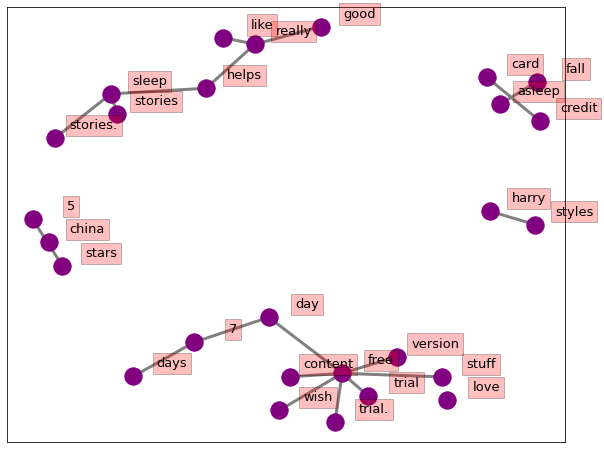

Words Co-occurence in Positive Reviews: Replika: My AI Friend


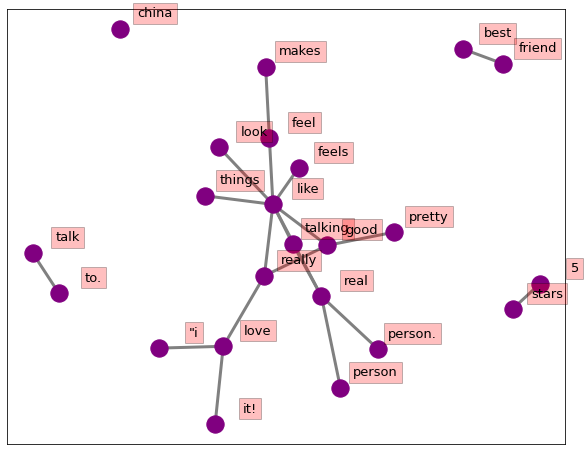

Words Co-occurence in Positive Reviews: MindDoc: Mood Tracker for Depression & Anxiety


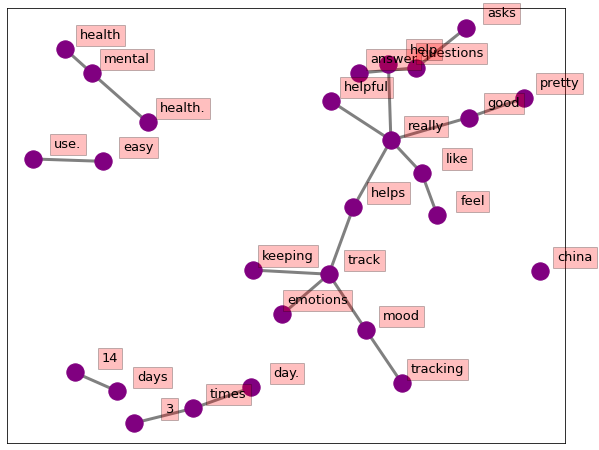

Words Co-occurence in Positive Reviews: Headspace: Meditation & Sleep


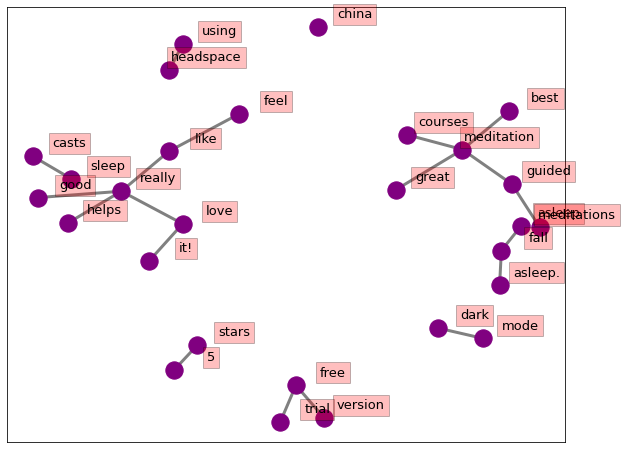

Words Co-occurence in Positive Reviews: Wysa: stress, depression & anxiety therapy chatbot


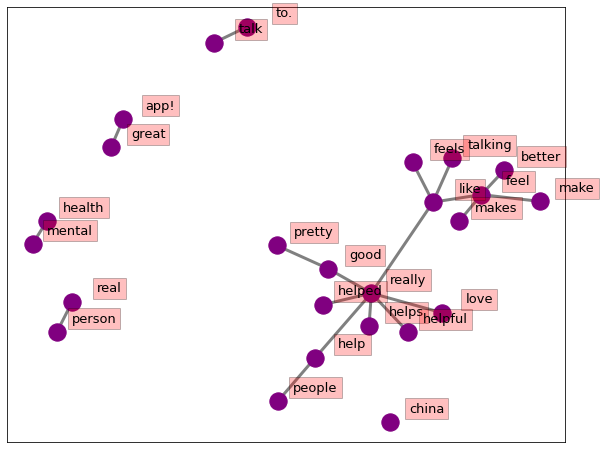

Words Co-occurence in Positive Reviews: UP! - Depression, Bipolar & Borderline Management


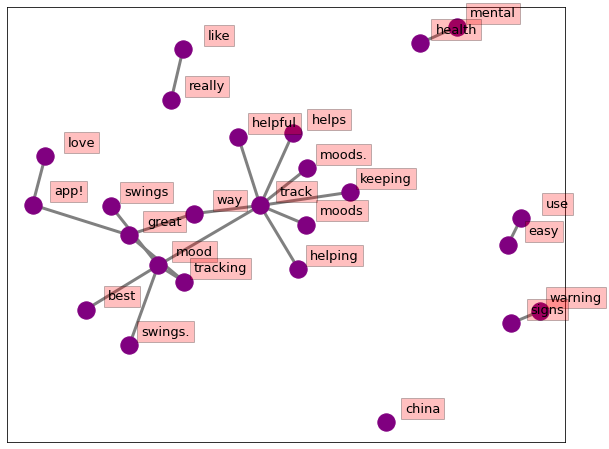

Words Co-occurence in Positive Reviews: Daylio - Diary, Journal, Mood Tracker


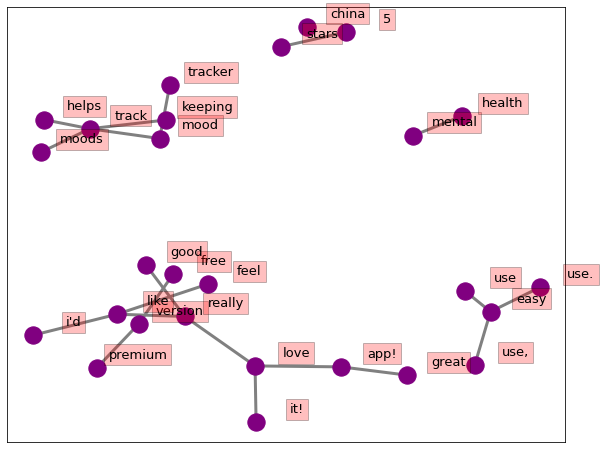

Words Co-occurence in Positive Reviews: MoodSpace - Stress, anxiety, & low mood self-help


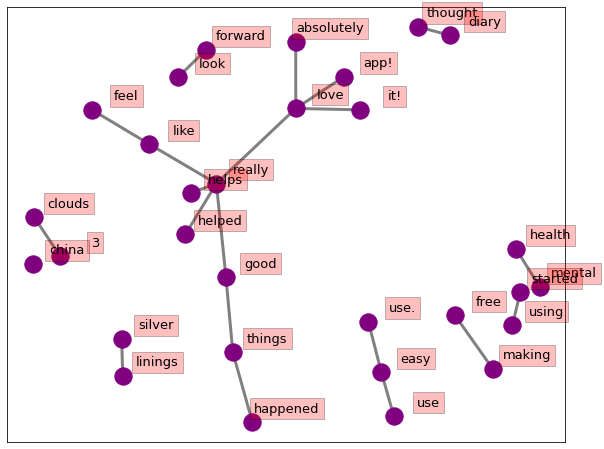

Words Co-occurence in Positive Reviews: Insight Timer - Meditation, Sleep, Music


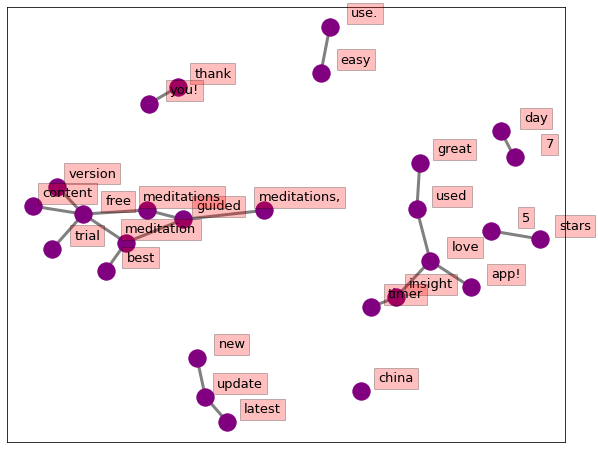

Words Co-occurence in Positive Reviews: Atom: Build a habit of meditation (For Beginners)


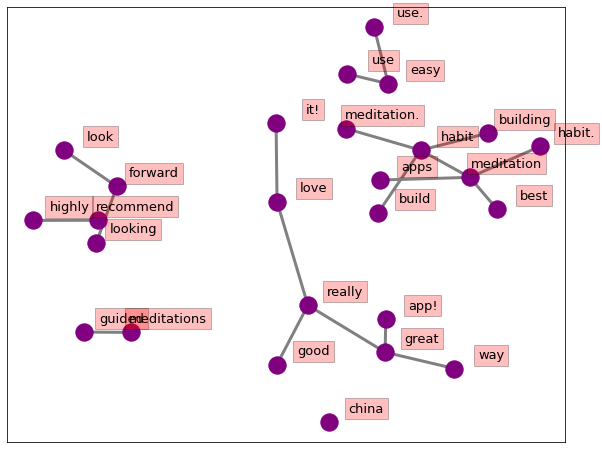

Words Co-occurence in Positive Reviews: Ten Percent Happier - Meditation & Sleep


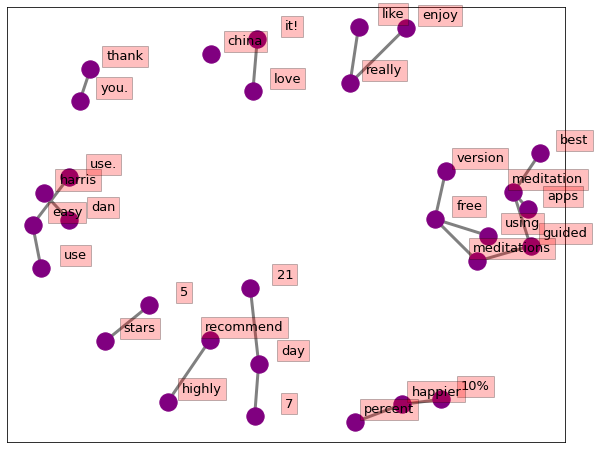

In [36]:
#bigrams
for app_id in app_ids: 
    reviews = []
    df = app_reviews_df[(app_reviews_df['appId'] == app_id) & (app_reviews_df['positive_reviews'] == True)]
    for i in range(len(df[df['appId'] == app_id])):
        reviews.append(df['content'].iloc[i].lower().split())
    reviews_all_words = list(itertools.chain(*reviews))
    stop_words = set(stopwords.words('english'))
    reviews_all_words = [word for word in reviews_all_words if word not in stop_words]
    reviews_all_words = [word for word in reviews_all_words if not word in ENGLISH_STOP_WORDS]
    reviews_all_words = [word for word in reviews_all_words if word not in my_collection_words]
    
    reviews_bigrams = list(nltk.bigrams(reviews_all_words))
    bigram_counts = collections.Counter(reviews_bigrams)
    bigram_df = pd.DataFrame(bigram_counts.most_common(20),columns=['bigram', 'count'])

    counts_review_words = collections.Counter(reviews_all_words)

    d = bigram_df.set_index('bigram').T.to_dict('records')

    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    G.add_node("china", weight=100)

    fig, ax = plt.subplots(figsize=(10, 8))

    pos = nx.spring_layout(G, k=2)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=16,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)
    
    print('Words Co-occurence in Positive Reviews: {app_name}'.format(app_name = app_dict[app_id]))
    plt.show()

##### Words Co-occurence in Negative Reviews

- We can see from the co-occurring words in negative reviews users think paid subscription and the lack of free content constitute an issue for them
- We can also see that despite giving overall negative reviews users still think the product is helpful

Words Co-occurence in Negative Reviews: Calm - Meditate, Sleep, Relax
None


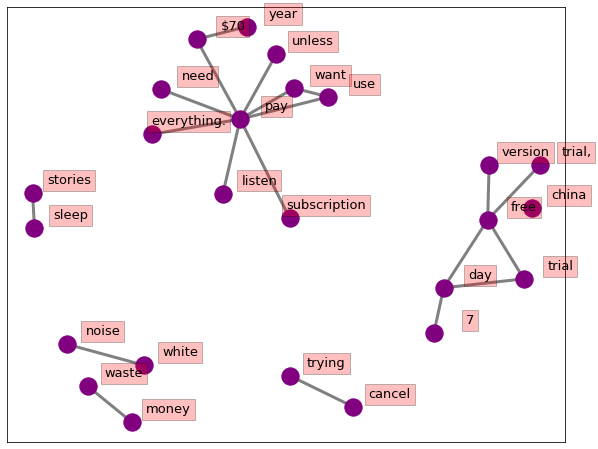

Words Co-occurence in Negative Reviews: Replika: My AI Friend
None


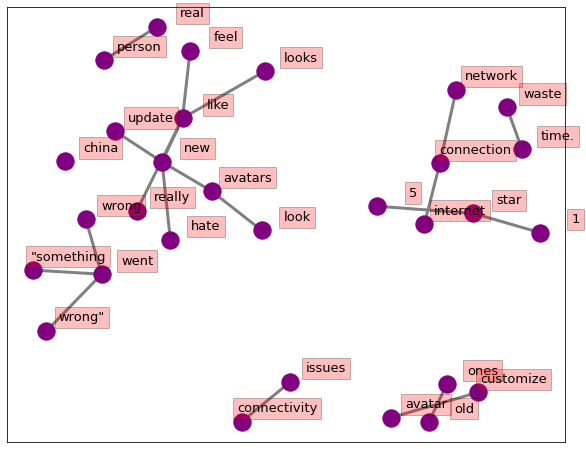

Words Co-occurence in Negative Reviews: MindDoc: Mood Tracker for Depression & Anxiety
None


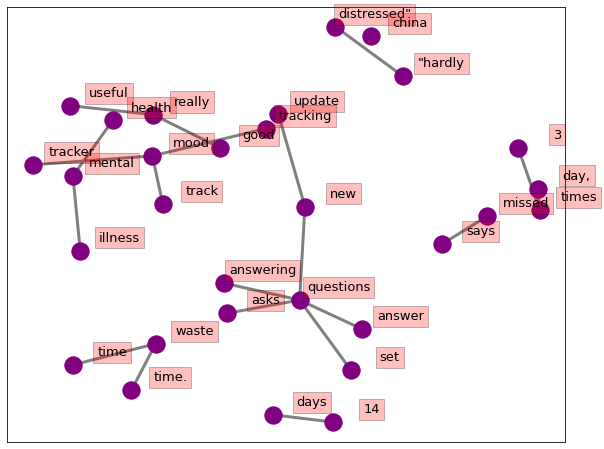

Words Co-occurence in Negative Reviews: Headspace: Meditation & Sleep
None


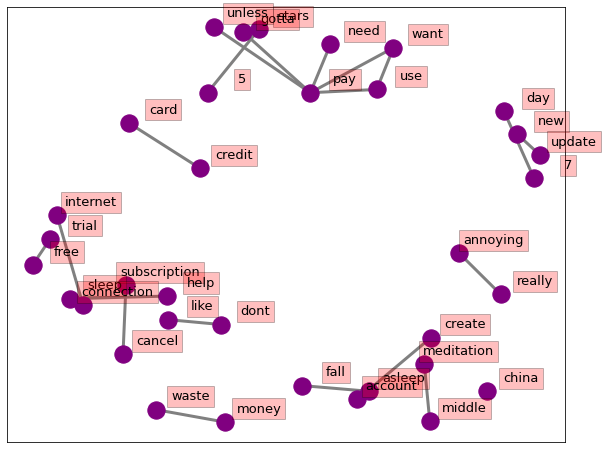

Words Co-occurence in Negative Reviews: Wysa: stress, depression & anxiety therapy chatbot
None


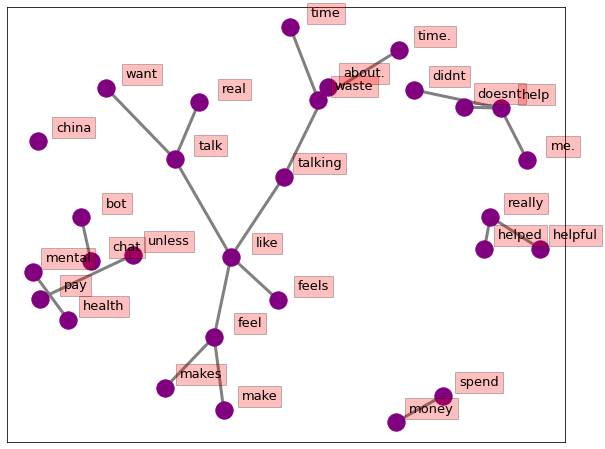

Words Co-occurence in Negative Reviews: UP! - Depression, Bipolar & Borderline Management
None


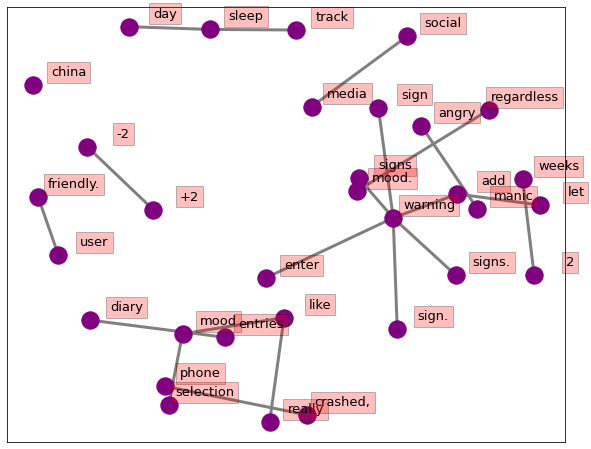

Words Co-occurence in Negative Reviews: Daylio - Diary, Journal, Mood Tracker
None


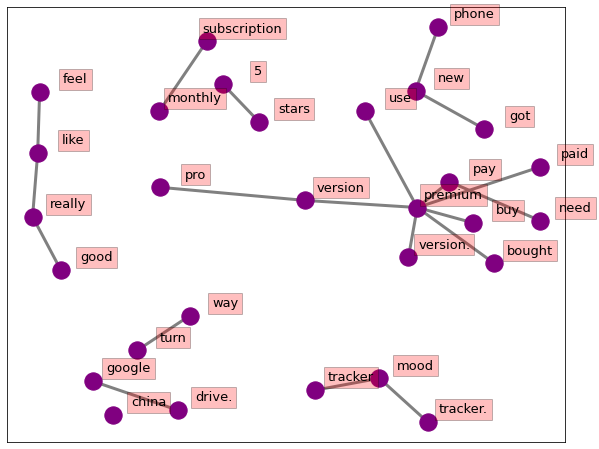

Words Co-occurence in Negative Reviews: MoodSpace - Stress, anxiety, & low mood self-help
None


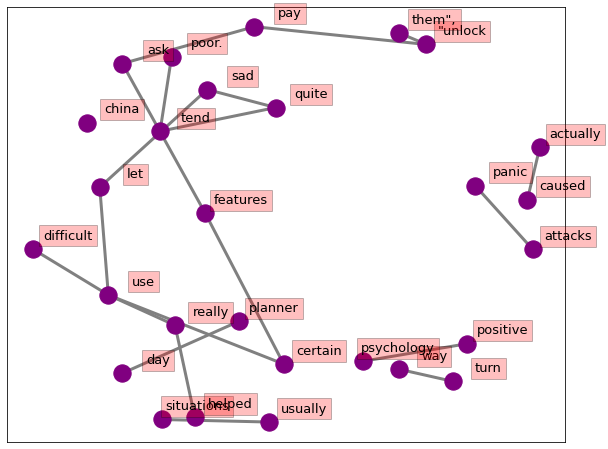

Words Co-occurence in Negative Reviews: Insight Timer - Meditation, Sleep, Music
None


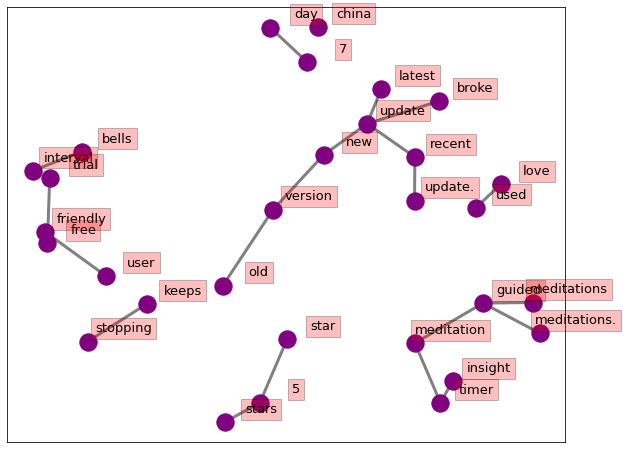

Words Co-occurence in Negative Reviews: Atom: Build a habit of meditation (For Beginners)
None


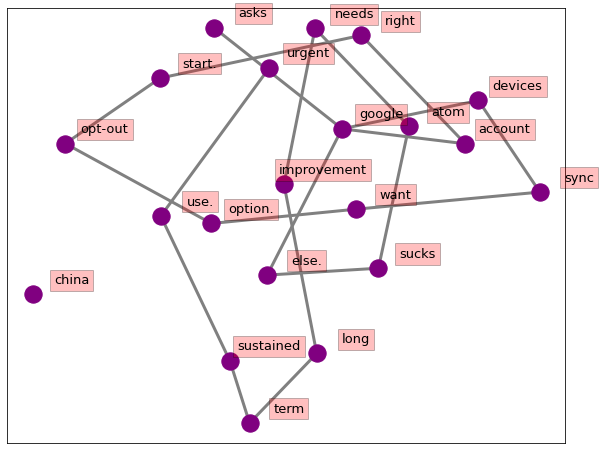

Words Co-occurence in Negative Reviews: Ten Percent Happier - Meditation & Sleep
None


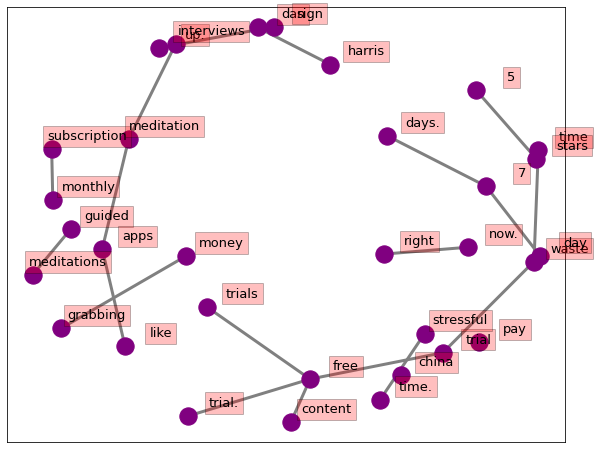

In [38]:
#bigrams
for app_id in app_ids: 
    reviews = []
    df = app_reviews_df[(app_reviews_df['appId'] == app_id) & (app_reviews_df['negative_reviews'] == True)]
    for i in range(len(df[df['appId'] == app_id])):
        reviews.append(df['content'].iloc[i].lower().split())
    reviews_all_words = list(itertools.chain(*reviews))
    stop_words = set(stopwords.words('english'))
    reviews_all_words = [word for word in reviews_all_words if word not in stop_words]
    reviews_all_words = [word for word in reviews_all_words if not word in ENGLISH_STOP_WORDS]
    reviews_all_words = [word for word in reviews_all_words if word not in my_collection_words]
    
    reviews_bigrams = list(nltk.bigrams(reviews_all_words))
    bigram_counts = collections.Counter(reviews_bigrams)
    bigram_df = pd.DataFrame(bigram_counts.most_common(20),columns=['bigram', 'count'])

    counts_review_words = collections.Counter(reviews_all_words)

    d = bigram_df.set_index('bigram').T.to_dict('records')

    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    G.add_node("china", weight=100)

    fig, ax = plt.subplots(figsize=(10, 8))

    pos = nx.spring_layout(G, k=2)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=16,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)
    
    print(print('Words Co-occurence in Negative Reviews: {app_name}'.format(app_name = app_dict[app_id])))
    plt.show()

### Insights for H4E

- It will lead to more success if the product provide enough quality free content to show what the user the app is about before charging for subscription. 
- The usefulness of the product is largely subjective and user tend to respond positively when as long as they feel the app is adding value and being helpful
- Users tend to respond positively to apps that charge reasonably and cheaply for paid services. 
- Users would also like to feel their privacy is in safe hands with the app they are using, especially when it concerns personal health information

### Future Research

- We can also use the data on American mental wellness published by federal and health organizations to study the overview of mental wellness among the population. We'll be able to identify opportunities to this area more efficiently with an understanding of mental wellness among demographics, age groups, and occupations, etc. 

### Regarding the ethics of consumer insights mining

- It is crucial that we respect the private information of users reviewining the app 
- It is also crucial that we acknowledge that there are bias in our study and that not hold the insights we generate about one app or one user against them  